In [22]:
import numpy as np
import random
import matplotlib.pyplot as plt
import matplotlib
import seaborn as sns
from tqdm import tqdm
from sklearn import datasets
from sklearn.utils import shuffle
font = {'weight' : 'bold',
        'size'   : 16}
matplotlib.rc('font', **font)


In [33]:
def generate_data(case, sparse=False):
    """Generate regression/classification data."""
    bunch = None
    if case == 'regression':
        bunch = datasets.load_boston()
    elif case == 'classification':
        bunch = datasets.fetch_20newsgroups_vectorized(subset='all')
    X, y = shuffle(bunch.data, bunch.target)
    offset = int(X.shape[0] * 0.8)
    X_train, y_train = X[:offset], y[:offset]
    X_test, y_test = X[offset:], y[offset:]
    X_train = np.array(X_train)
    X_test = np.array(X_test)
    y_test = np.array(y_test).reshape(-1, 1)
    y_train = np.array(y_train).reshape(-1, 1)
    data = {'X_train': X_train, 'X_test': X_test, 'y_train': y_train,
            'y_test': y_test}
    return X_train, y_train, X_test, y_test

In [34]:
def create_data(d, p, n, deg=1, n_test=5000):
   
    # randX = np.random.randn(n, d)
    # randY = np.random.randn(n, p)
    Cx = np.eye(d)#np.diag(np.random.rand(d,))#+randX.T@randX/N
    Cy = np.diag(np.random.rand(p,))*1
    Lx = np.linalg.cholesky(Cx)
    Ly = np.linalg.cholesky(Cy)

    X_tr = np.random.randn(n, d)@Lx
    X_te = np.random.randn(n_test, d)@Lx
    
    
    w_true = np.random.randn(X_tr.shape[1],p)
    Y_tr = X_tr@w_true + np.random.randn(n,p)@Ly
    Y_te = X_te@w_true + np.random.randn(n_test,p)@Ly
    
    X_te = np.hstack([X_te**i for i in range(1, deg+1)])
    X_tr = np.hstack([X_tr**i for i in range(1, deg+1)])
    
    if deg > 1:
        zero = np.zeros((d*(deg-1), p))
        w_true = np.vstack([w_true, zero])
    assert w_true.shape[0] == X_tr.shape[1]
    return X_tr, Y_tr, X_te, Y_te, w_true, Cx, Cy

In [35]:
def error(X, y, lanbda, w):
    return 1/(2*X.shape[0])*np.sum((X@w-y)**2) + lanbda/2*np.trace(w.T@w)

In [36]:
def compute_hessian(X, lanbda):
    H = X.T@X/X.shape[0]+lanbda*np.eye(X.shape[1])
    return H, np.linalg.inv(H)
#     return H, np.linalg.pinv(H)


In [37]:
def solve_ls(X, y, H_tr_1):
    w_mle = H_tr_1@X.T@y/X.shape[0]
    return w_mle


In [38]:
def compute_V_C(X, y, lanbda, w):
    n, d = X.shape
    p = y.shape[1]
    V = np.zeros((d, d))
    mean_grad = np.zeros((d, p))
    for i in range(n):
        grad_i = np.outer(X[i], X[i]@w-y[i])+lanbda*w
        mean_grad += grad_i/n
        V += grad_i@grad_i.T/n
    C = V - mean_grad@mean_grad.T
    return V, C
# stoch_grad_tr = X_tr.T@(X_tr@w_mle - Y_tr)/n
# V_tr = stoch_grad_tr@stoch_grad_tr.T


In [39]:
def main_fun(d, p, n, lanbda, deg=1):
    # Create data set for training and testing
#     X_tr, Y_tr, X_te, Y_te, w_true, Cx, Cy = create_data(d, p, n, deg=deg)
    X_tr, Y_tr, X_te, Y_te = generate_data('regression')
    # compute hessians
    H_tr, H_tr_1 = compute_hessian(X_tr, lanbda)
#     print(np.linalg.cond(H_tr))
    H_te, H_te_1 = compute_hessian(X_te, lanbda)
    # solve the problem
    w_mle = solve_ls(X_tr, Y_tr, H_tr_1)   
    # compute the covariances
    V_tr, C_tr = compute_V_C(X_tr, Y_tr, lanbda, w_mle)
    V_te, C_te = compute_V_C(X_te, Y_te, lanbda, w_mle)
    # compute plotting val
    trH1C_tr = np.trace(H_tr_1@C_tr)/n
    trH1C_te = np.trace(H_te_1@C_te)/n
    err_tr = error(X_tr, Y_tr, lanbda, w_mle)
    err_te = error(X_te, Y_te, lanbda, w_mle)
    gap = err_te - err_tr
    # theoretical test error
#     dw = w_mle-w_true
#     err_te_th = .5*np.trace(dw.T@Cx@dw + Cy)+lanbda/2*np.sum(w_mle**2)
    return trH1C_tr, trH1C_te, err_tr, err_te, gap#, err_te_th, err_te_th-err_tr

In [40]:
# d = 90# data dimension
# n = 50000 # training set size
# p = 1# output dimension
# lanbda = 0
# trH1C_tr, trH1C_te, err_tr, err_te, gap = main_fun(d, p, n, lanbda)


In [50]:
def grid_compute(N = 40):
    trH1C_tr_list = []
    trH1C_te_list = []
    gap_list = []
    err_tr_list = []
    err_te_list = []
    err_te_th_list = []
#     gap_th_list = []
    for i in range(N):
        if i % 10 == 0:
            print(f'{i+1}/{N}')
        d = np.random.randint(15, 200)
        p = np.random.randint(1, 10)
        n = np.random.randint(500, 10000)
        lanbdas = np.logspace(-5, 1, 15)*0
        lanbda = lanbdas[np.random.randint(15)]*0
        deg = np.random.randint(1,5)
        #, err_te_th, gap_th
        trH1C_tr, trH1C_te, err_tr, err_te, gap = main_fun(d, p, n, lanbda, deg=deg)
        trH1C_tr_list.append(trH1C_tr)
        trH1C_te_list.append(trH1C_te)
        gap_list.append(gap)
        err_te_list.append(err_te)
        err_tr_list.append(err_tr)
#         err_te_th_list.append(err_te_th)
#         gap_th_list.append(gap_th)
    return np.array(trH1C_tr_list), np.array(trH1C_te_list), np.array(gap_list), np.array(err_tr_list), np.array(err_te_list)#, np.array(err_te_th_list), np.array(gap_th_list)

In [51]:
# trH1C_tr_list, trH1C_te_list, gap_list, err_tr_list, err_te_list, err_te_th_list, gap_th_list, = grid_compute(50)
trH1C_tr_list, trH1C_te_list, gap_list, err_tr_list, err_te_list = grid_compute(250)

1/250
11/250
21/250
31/250
41/250
51/250
61/250
71/250
81/250
91/250
101/250
111/250
121/250
131/250
141/250
151/250
161/250
171/250
181/250
191/250
201/250
211/250
221/250
231/250
241/250


In [52]:
np.corrcoef(trH1C_tr_list, gap_list)

array([[ 1.        , -0.09727867],
       [-0.09727867,  1.        ]])

In [53]:
def plot(x, y):
    ind = np.argsort(x).astype(np.int16)
    r2 = np.corrcoef(x[ind], y[ind])[0,1]
    plt.figure(figsize=(15,8))    
    plt.plot(x[ind], y[ind], "o", label=fr'$R^2={r2}$')
    plt.plot(x[ind], x[ind])
    scale = 'linear'
    plt.legend()
    plt.grid()
    plt.yscale('linear')
    plt.xscale(scale)

Text(0.5,1,'Gap vs $Tr(H^{-1} C)$ on train set at $\\theta_{MLE}$')

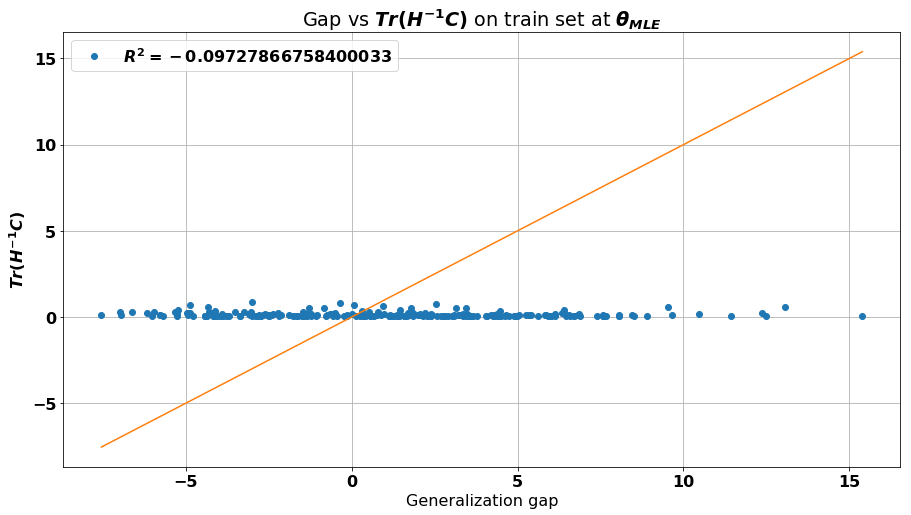

In [54]:

plot(gap_list, trH1C_tr_list)
plt.xlabel('Generalization gap')
plt.ylabel(r'$Tr(H^{-1} C)$')
plt.title(r'Gap vs $Tr(H^{-1} C)$ on train set at $\theta_{MLE}$')
# plt.savefig('trh1c_gap.png')

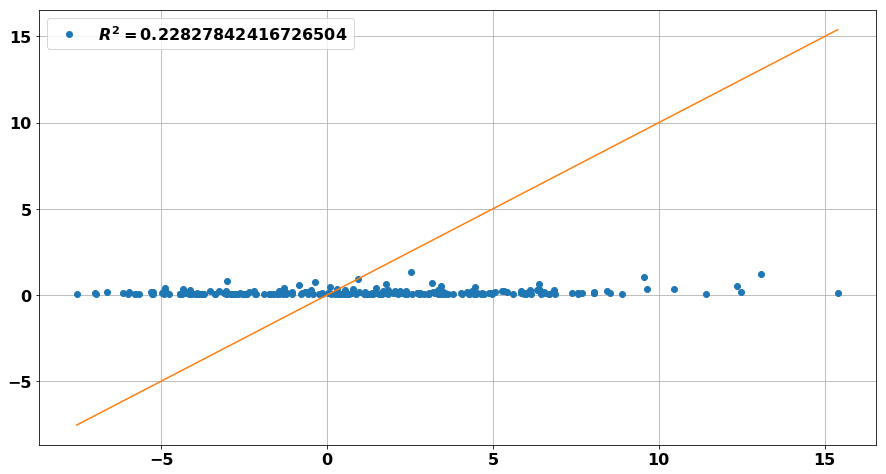

In [55]:
plot(gap_list, trH1C_te_list)

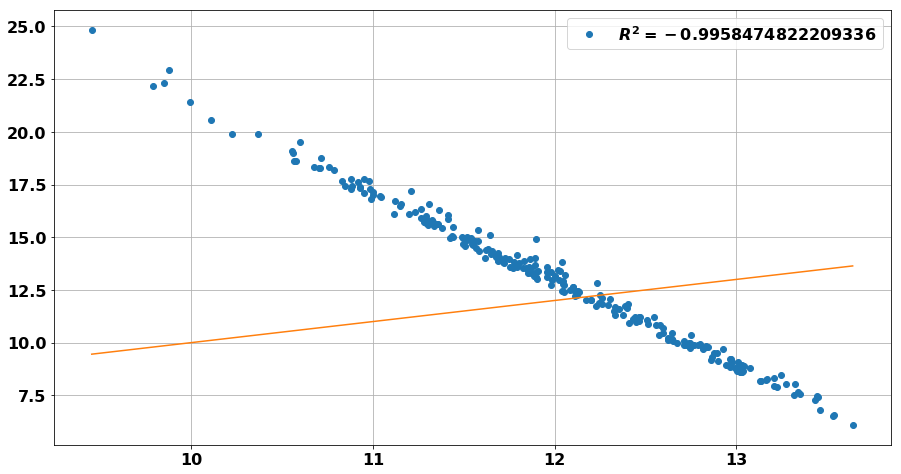

In [56]:
plot(err_tr_list, err_te_list)

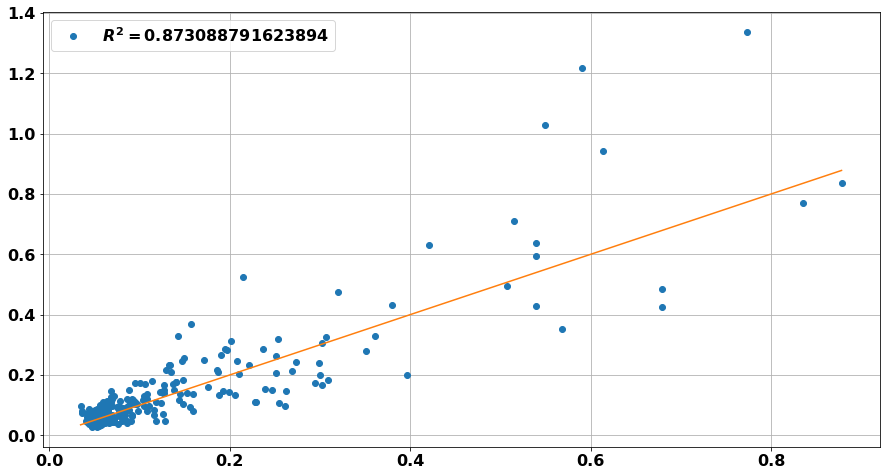

In [57]:
plot(trH1C_tr_list, trH1C_te_list)

In [58]:
# plot(gap_th_list, gap_list)

In [ ]:
gap_list